In [1]:
pip install transformers scipy -q

Note: you may need to restart the kernel to use updated packages.


---

# Persistent Homology of Attention Probability Distributions

---

In [2]:
import torch
from transformers import GPT2Model, GPT2Tokenizer
from scipy.spatial.distance import jensenshannon
from scipy.special import softmax
import numpy as np

def compute_js_distance(input_text, subset_text, layer, head):
    # Initialize tokenizer and model
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
    model = GPT2Model.from_pretrained('gpt2-xl', output_attentions=True)
    model.eval()

    # Tokenize input and subset text
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    subset_ids = tokenizer.encode(subset_text, return_tensors='pt')

    # Get model outputs
    with torch.no_grad():
        outputs = model(input_ids)
    
    # Get attention from specified layer and head
    attention = outputs.attentions[layer][0, head].numpy()
    
    # Apply softmax to convert to probability distribution
    prob_distributions = softmax(attention, axis=-1)
    
    # Identify the positions of subset tokens in input
    subset_positions = [i for i, id in enumerate(input_ids[0]) if id in subset_ids[0]]
    
    # Select the probability distributions associated with subset tokens
    subset_distributions = prob_distributions[subset_positions]
    
    # Compute pairwise Jensen-Shannon distances
    num_tokens = len(subset_positions)
    distance_matrix = np.zeros((num_tokens, num_tokens))
    
    for i in range(num_tokens):
        for j in range(num_tokens):
            distance_matrix[i, j] = jensenshannon(subset_distributions[i], subset_distributions[j])
    
    return distance_matrix


In [3]:
import gudhi as gd

def compute_persistent_homology(distance_matrix, max_dimension=2):
    # Create a Rips complex from the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=1.0)

    # Construct a simplex tree from the Rips complex
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)

    # Compute the persistent homology of the simplex tree
    persistence = simplex_tree.persistence()

    # Draw the persistence diagram
    gd.plot_persistence_diagram(persistence)

    return persistence

In [4]:
input_text_1 = "In the realm of linguistics, it is crucial to foster a deep understanding of language structures and their interconnections. This understanding is not simply about memorizing vocabulary or grammar rules, but delving into the intricate details of phonetics, semantics, and syntax. However, the common elements that we often focus on, such as morphemes, phonemes, and syntax rules, are merely the tip of the iceberg. Beneath the surface, there lies a vast field of cognitive, social, and historical factors that play significant roles in shaping a language. Grasping these underlying influences is what sets apart a competent linguist from a casual language learner."
subset_text = "foster a deep understanding"
layer = 5
head = 3
distances_1 = compute_js_distance(input_text_1, subset_text, layer, head)

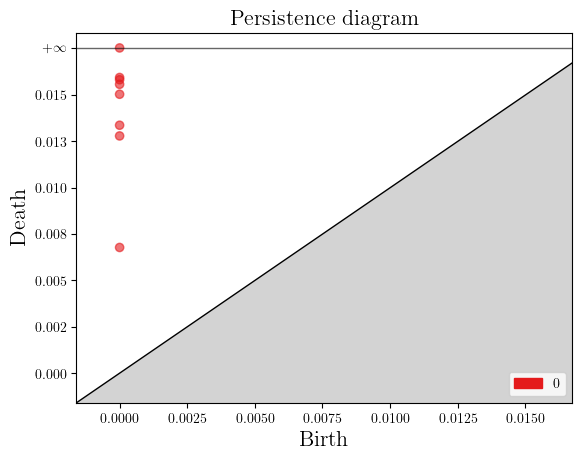

In [5]:
persistence_1 = compute_persistent_homology(distances_1)

In [6]:
# Example usage:
input_text_2 = "In the field of computer science, the aim is to foster a deep understanding of algorithms and data structures. This knowledge goes beyond merely learning a programming language or writing a simple script. It involves diving into the core principles of computation and how data is manipulated to solve real-world problems. Basic coding skills and knowledge of a few algorithms are merely the tip of the iceberg. Beneath this surface, lies the unexplored depth of complexity theory, cryptography, machine learning, and more. Only by engaging with these advanced topics can one truly become proficient in the discipline of computer science."
subset_text = "foster a deep understanding"
layer = 5
head = 3
distances_2 = compute_js_distance(input_text_2, subset_text, layer, head)

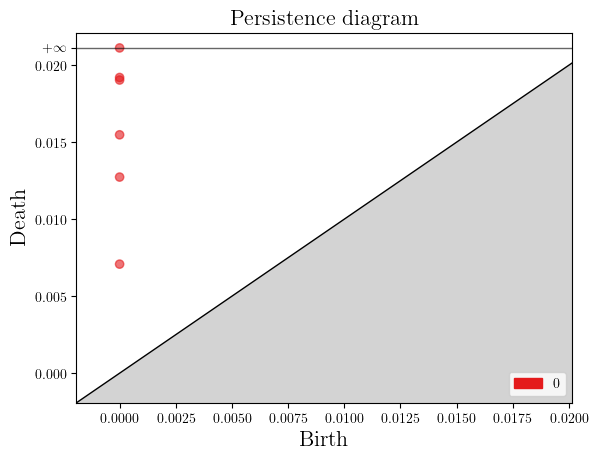

In [7]:
persistence_2 = compute_persistent_homology(distances_2)

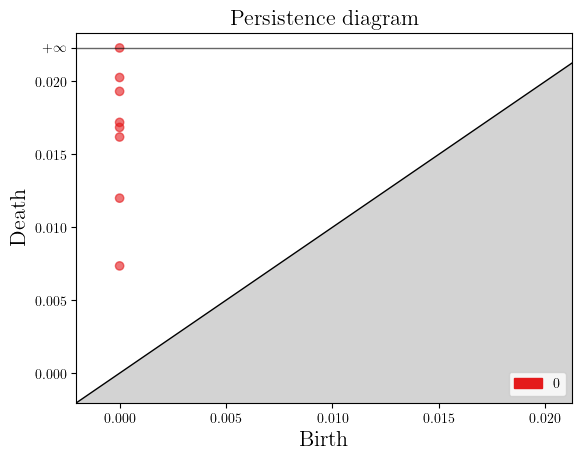

In [8]:
input_text_3 = "In the realm of environmental science, we strive to foster a deep understanding of the Earth's ecosystems and their delicate balance. This understanding is not just about knowing the names of different species or understanding the water cycle. It requires a comprehensive study of biodiversity, climate change, and pollution. Knowing a few facts about global warming or endangered species is only the tip of the iceberg. Below this surface, there are numerous intricate relationships between living organisms and their environment, and understanding these relationships is crucial for preserving our planet for future generations."
subset_text = "foster a deep understanding"
layer = 5
head = 3
distances_3 = compute_js_distance(input_text_3, subset_text, layer, head)
persistence_3 = compute_persistent_homology(distances_3)

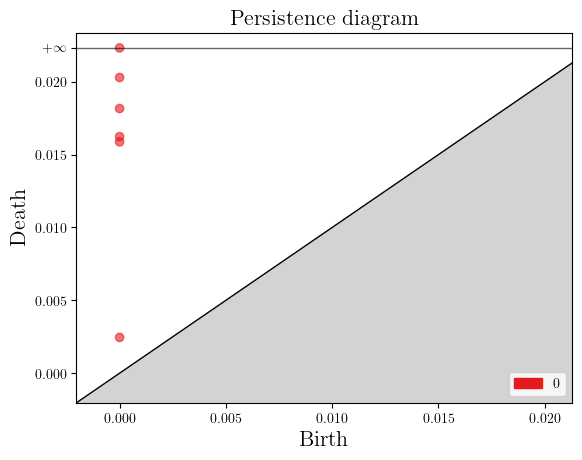

In [9]:
input_text_4 = "When it comes to teaching history, our goal is to foster a deep understanding of the events, cultures, and people that have shaped our world. This is not simply about memorizing dates or names; it's about exploring the causes and effects of major events, understanding different perspectives, and seeing the bigger picture. Knowing the main events of World War II or the key figures of the Renaissance is just the tip of the iceberg. Beneath this, there's a wealth of context, from political and economic factors to social and cultural movements, that played pivotal roles in shaping history. Understanding these aspects is key to gaining a comprehensive grasp of history."
subset_text = "foster a deep understanding"
layer = 5
head = 3
distances_4 = compute_js_distance(input_text_4, subset_text, layer, head)
persistence_4 = compute_persistent_homology(distances_4)

In [10]:
import numpy as np

def transform_persistence_diagram(diagram):
    # Remove the dimension from each feature and return the transformed diagram
    return [(birth, death) for dimension, (birth, death) in diagram]

def compute_bottleneck_distances(persistence_diagrams, p=2):
    n = len(persistence_diagrams)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            diagram1 = transform_persistence_diagram(persistence_diagrams[i])
            diagram2 = transform_persistence_diagram(persistence_diagrams[j])
            distance = gd.bottleneck_distance(diagram1, diagram2, e=0.01)
            distances[i, j] = distance
            distances[j, i] = distance
    return distances

# Example usage:
persistence_diagrams = [persistence_1, persistence_2, persistence_3, persistence_4]
bn_distances = compute_bottleneck_distances(persistence_diagrams)
print(bn_distances)

[[0.         0.00480008 0.00506708 0.0050742 ]
 [0.00480008 0.         0.00506708 0.0050742 ]
 [0.00506708 0.00506708 0.         0.0050742 ]
 [0.0050742  0.0050742  0.0050742  0.        ]]


In [11]:
from gudhi.hera import wasserstein_distance
import numpy as np

def compute_wasserstein_distances(persistence_diagrams, p=2):
    n = len(persistence_diagrams)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            diagram1 = transform_persistence_diagram(persistence_diagrams[i])
            diagram2 = transform_persistence_diagram(persistence_diagrams[j])
            distance = wasserstein_distance(diagram1, diagram2, order=1., internal_p=2.)
            distances[i, j] = distance
            distances[j, i] = distance
    return distances

# Example usage:
persistence_diagrams = [persistence_1, persistence_2, persistence_3, persistence_4]
w_distances = compute_wasserstein_distances(persistence_diagrams)
print(w_distances)

[[0.         0.02701646 0.01542429 0.03101921]
 [0.02701646 0.         0.02708261 0.01049631]
 [0.01542429 0.02708261 0.         0.02763311]
 [0.03101921 0.01049631 0.02763311 0.        ]]


---

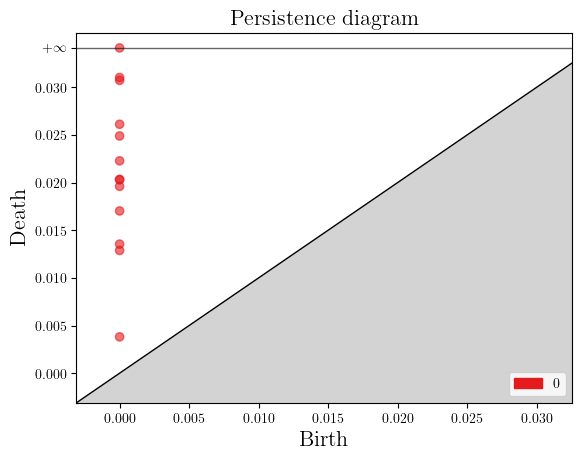

In [12]:
subset_text_2 = "the tip of the iceberg"
distances_5 = compute_js_distance(input_text_1, subset_text_2, layer, head)
persistence_5 = compute_persistent_homology(distances_5)

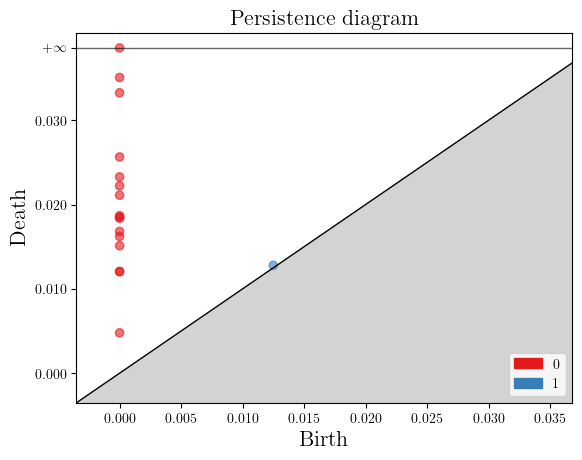

In [13]:
distances_6 = compute_js_distance(input_text_2, subset_text_2, layer, head)
persistence_6 = compute_persistent_homology(distances_6)

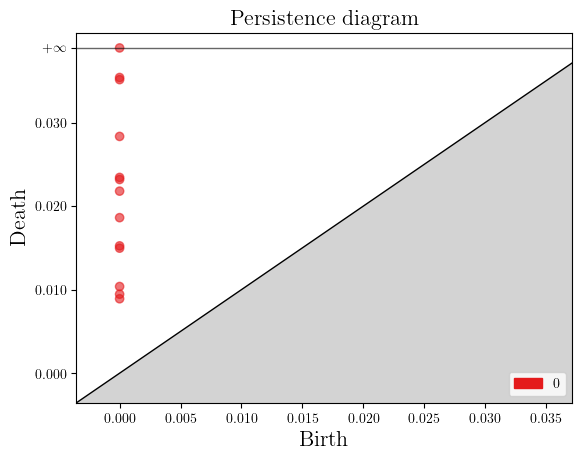

In [14]:
distances_7 = compute_js_distance(input_text_3, subset_text_2, layer, head)
persistence_7 = compute_persistent_homology(distances_7)

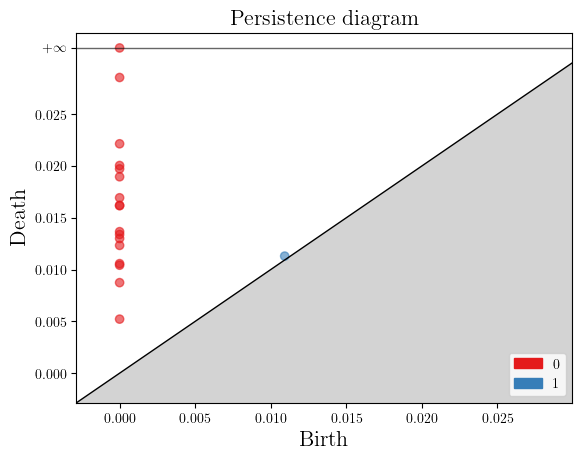

In [15]:
distances_8 = compute_js_distance(input_text_4, subset_text_2, layer, head)
persistence_8 = compute_persistent_homology(distances_8)

In [16]:
persistence_diagrams_2 = [persistence_5, persistence_6, persistence_7, persistence_8]
w_distances_2 = compute_wasserstein_distances(persistence_diagrams_2)
print(w_distances_2)

[[0.         0.04855179 0.03460223 0.07168527]
 [0.04855179 0.         0.04976319 0.06339779]
 [0.03460223 0.04976319 0.         0.07829196]
 [0.07168527 0.06339779 0.07829196 0.        ]]
